## Notebook to calculate cellular growth rate and productivity using Hynes et al. 2023 method

In [5]:
# suppress warnings
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np
import datetime
import xarray as xr
from scipy import stats
from astral import Observer
from astral.sun import sunrise
from astral.sun import sunset

# import functions from custom modules
import sys
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from diel_tools import *
from fig_tools import *
from tsd_functions import *
from rate_functions import *
from simulation_tools import *

In [ ]:
# try reading in feather g3 influx file
pd.read_feather('/Users/Kathy/Desktop/UW/colocalization/feather_data/all_gradients_pro_influx.feather')

In [6]:
#import zinser data over
# read in flow cytometry data
culture_data=pd.read_csv('simulation_data/zinser_figure2a.csv')
psd_data=pd.read_csv('simulation_data/zinser_psd.csv')

#### reformat to calculate hourly average Qc ####
# get experimental time from culture dataset
X = list(culture_data['exper time'])
# get size classes from psd data columns
Y = list(psd_data.columns[1:].astype(float))
# get particle size distrubition data from dataframe
Z = psd_data.iloc[:,1:].T.to_numpy()

# make new dataframe with particle size distribution data and reset the index
df = pd.DataFrame(data=Z, columns=X, index=Y).reset_index()
# rename column to size_bin
df.rename(columns={'index':'size_bin'},inplace=True)
# reformat data from wide to long
df_long=pd.melt(df, id_vars=['size_bin'], var_name='hour', value_name='abundance')
# calculate sum of each size bin using size and abundance
df_long['Qc_sum'] = df_long['size_bin'] * df_long['abundance']
# filter out size classes with no abundance
df_long = df_long[df_long.abundance > 0]

# group by cruise and date to get n and summed qc by the hour
df_group = df_long.groupby(['hour']).sum().reset_index()
# get mean Qc per hour and convert Qc from fg -> pg
df_group['Qc_hour'] = (df_group['Qc_sum']/df_group['abundance'])/1000
# subset just the columns we care about
pro_data = df_group[['hour','Qc_hour']]

#### Add in PAR and measurements data ####
# get PAR data
ds = xr.open_dataset('simulation_data/zinser_processed.nc',
                    decode_times=False)
pro_data['par']=ds.PAR.values
# get abundance
pro_data['abundance']=ds.abundance.values
# get c-fixation and loss data
gt = xr.open_dataset('simulation_data/zinser_ground_truth.nc',
                    decode_times=False)
# get carbon fixation for all rows in pg
pro_data['GPP']=gt.carbonfix.values/1000
# get carbon loss for all rows except last in pg
pro_data.loc[0:23,'carbonloss']=gt.carbonloss.values/1000
# add net c-fiszation for all rows
pro_data['NPP'] = pro_data['GPP']-pro_data['carbonloss']


# create 10 day simulated data for Qc data
ten_days=generate_simulated(pro_data, 10)

# add a sub row for sunrise in day 1
new_row = pd.DataFrame({'hour':0, 'Qc_hour':np.nan, 'par':np.nan,
                        'abundance':np.nan, 'GPP':np.nan, 'carbonloss':np.nan,
                        'NPP':np.nan},
                                                            index =[0])

# add to top of df
ten_days=pd.concat([new_row, ten_days]).reset_index(drop = True)
# reset hours
ten_days.hour=np.arange(0,len(ten_days)*2,2)

# set each experiment day
ten_days['experiment_day']=ten_days['hour'] // 24

In [57]:
def block_run(data, days, model, noise=0,add_trend=False, trend_df=None, trend=None):
    # list of data blokcs to remove 
    to_remove=[0.1, 0.25, 0.4, 0.5, 0.6]
    row_list=[]
    for remove in to_remove:
        # run model
        print('running...')
        bagged, rmse, mase, resid_percent=run_full_model(data, 
                                                         days=days, 
                                                         remove=remove,
                                                         blocks=True,
                                                         noise=noise,
                                                         add_trend=add_trend,
                                                         trend_df=trend_df,
                                                         model=model)
        # save rows
        row = {'model':model,'remove':remove, 'trend': trend, 'noise': noise, 'rmse':rmse, 'mase':mase}
        print(row)
        row_list.append(row)
    # return rows as df
    return(pd.DataFrame(row_list), bagged)

def run_block_simulations(pro_data, data_len, model, add_trend=False, trend_df=None, trend=None,
                                show_plots=True, model_runs=100, save_data=False):
    # list of noise to add
    noise_percents=[0.25, 0.5, 0.75, 1]
    # save dfs here
    error_dfs=[]
    bagged_dfs=[]
    for i in range(0,model_runs):
        # save data in df
        runs=pd.DataFrame(columns=['model','remove','trend','noise','rmse','mase'])
        bagged_list=[]
        print(i)
        for noise in noise_percents:
            # run model for several iterations
            try:
                run,bagged=block_run(pro_data, data_len, model, noise=noise,
                                     add_trend=add_trend, trend_df=trend_df, trend=trend)
            except:
                print('moving on..')
                continue
            # list of dicts to df
            runs=pd.concat([runs,run])
            bagged_list.append(bagged)
        # save df to list
        error_dfs.append(runs.reset_index(drop = True))
        bagged_dfs.append(bagged_list)
    if save_data:
        runs.to_pickle(f'simulation_data/trend_block_noise_{model}_error')
    # return list of dfs and bagged values
    return(error_dfs,bagged_dfs)

In [ ]:
error_dfs, bagged_dfs=run_block_simulations(pro_data, 10, model='naive', 
                     add_trend=True, trend_df=trend1_df, trend=1, model_runs=1)

In [72]:
## run some trend+missing data experiments while we wait for trend+noise experiments
# generate some data
days=10
## trend 1 = simple linear function (keep data reasonable)
# linear by multiplying qc
trend1 = np.linspace(1, 1.4, days)
# trend 2 = trend 1 but up and down for 10 days total
up=np.linspace(1,1.4,int(days/2))
down=np.flip(up)
trend2=np.concatenate((up, down))

# trends 1 and 2 experiments (10 days long)
sim_df = generate_simulated(pro_data, 10)
x = sim_df.index

# get trends
trend1_df=add_trend(sim_df, trend1)
trend2_df=add_trend(sim_df, trend2)
trend_dfs = [trend1_df, trend2_df]
trends=[1,2]
# set model names
models=['baseline','naive','stl','rolling']

# save
error_dfs=[]
bagged_dfs=[]
# run each model for each simulated trend dataset (run rolling separately, try to optimize it)
for trend_df,trend in zip(trend_dfs, trends):
    for model in models:
        print(model)
        # run model with noise
        df, bagged=run_block_simulations(pro_data, 10, model=model, 
                     add_trend=True, trend_df=trend_df, trend=trend, model_runs=10)
        # save model information
#         bagged['model']=model
#         bagged['trend']=trend
#         bagged['noise']=df.remove.values[0]
        error_dfs.append(df)
        bagged_dfs.append(bagged)

baseline
0
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 1, 'noise': 0.25, 'rmse': 0.002825590530473686, 'mase': 2.9525091385734235}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 1, 'noise': 0.25, 'rmse': 0.002557550524019237, 'mase': 2.5899149924844247}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 1, 'noise': 0.25, 'rmse': 0.002273832608672377, 'mase': 2.587942781751895}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 1, 'noise': 0.25, 'rmse': 0.0033197988280048597, 'mase': 3.7655461681362743}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 1, 'noise': 0.25, 'rmse': 0.0024643122872879644, 'mase': 2.477760629170346}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 1, 'noise': 0.5, 'rmse': 0.005004091968163906, 'mase': 5.578280589804375}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 1, 'noise': 0.5, 'rmse': 0.004042497421835859, 'mase': 4.229793043455459}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 1, 

{'model': 'baseline', 'remove': 0.5, 'trend': 1, 'noise': 0.25, 'rmse': 0.002950031468330739, 'mase': 3.1105792128455914}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 1, 'noise': 0.25, 'rmse': 0.0031754452175127065, 'mase': 3.781083091739523}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 1, 'noise': 0.5, 'rmse': 0.004858969416305213, 'mase': 5.2967125276697615}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 1, 'noise': 0.5, 'rmse': 0.004247164163742418, 'mase': 4.463808014884688}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 1, 'noise': 0.5, 'rmse': 0.004872325095761634, 'mase': 5.2912705279427374}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 1, 'noise': 0.5, 'rmse': 0.004187764491416093, 'mase': 4.535146219670347}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 1, 'noise': 0.5, 'rmse': 0.004063006398280159, 'mase': 4.59781033267233}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 1, 'noise': 0.75, 'rmse': 0.005

{'model': 'baseline', 'remove': 0.25, 'trend': 1, 'noise': 0.5, 'rmse': 0.0039587022456345974, 'mase': 4.34967191731163}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 1, 'noise': 0.5, 'rmse': 0.004977220551243082, 'mase': 5.346602211449067}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 1, 'noise': 0.5, 'rmse': 0.005876559636308234, 'mase': 6.389875135724233}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 1, 'noise': 0.5, 'rmse': 0.0030735159027318977, 'mase': 2.9548119626127676}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 1, 'noise': 0.75, 'rmse': 0.006645176834986434, 'mase': 7.093115954734937}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 1, 'noise': 0.75, 'rmse': 0.0061719169366291245, 'mase': 6.436192648560064}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 1, 'noise': 0.75, 'rmse': 0.006323851006200387, 'mase': 7.176867624041196}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 1, 'noise': 0.75, 'rmse': 0.0

{'model': 'baseline', 'remove': 0.6, 'trend': 1, 'noise': 0.5, 'rmse': 0.0035766828071547097, 'mase': 4.1047082874181156}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 1, 'noise': 0.75, 'rmse': 0.006986894543739358, 'mase': 7.714913513588632}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 1, 'noise': 0.75, 'rmse': 0.007800632255721032, 'mase': 8.189901097522503}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 1, 'noise': 0.75, 'rmse': 0.004512183827128993, 'mase': 4.970992852011666}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 1, 'noise': 0.75, 'rmse': 0.0073847255406727964, 'mase': 7.715555009248207}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 1, 'noise': 0.75, 'rmse': 0.006233642146374817, 'mase': 7.166897987556639}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 1, 'noise': 1, 'rmse': 0.007293065717845379, 'mase': 7.744378079713738}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 1, 'noise': 1, 'rmse': 0.0075

{'model': 'naive', 'remove': 0.5, 'trend': 1, 'noise': 0.75, 'rmse': 0.0027184846455113564, 'mase': 3.1626017824643418}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 1, 'noise': 0.75, 'rmse': 0.005321693152265351, 'mase': 5.090286599153782}
running...
{'model': 'naive', 'remove': 0.1, 'trend': 1, 'noise': 1, 'rmse': 0.0024520018791945866, 'mase': 2.6290714400357937}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 1, 'noise': 1, 'rmse': 0.003641953494978422, 'mase': 4.623300027930768}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 1, 'noise': 1, 'rmse': 0.00566108153835837, 'mase': 5.767190920452297}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 1, 'noise': 1, 'rmse': 0.0027666722922133915, 'mase': 2.843609715324297}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 1, 'noise': 1, 'rmse': 0.0030655125581794175, 'mase': 3.4296773436141184}
3
running...
{'model': 'naive', 'remove': 0.1, 'trend': 1, 'noise': 0.25, 'rmse': 0.0015326550395523377, 'mase': 1.4

{'model': 'naive', 'remove': 0.1, 'trend': 1, 'noise': 0.25, 'rmse': 0.0015220808332268147, 'mase': 1.5974558508311232}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 1, 'noise': 0.25, 'rmse': 0.001524737133697188, 'mase': 1.6046857125135028}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 1, 'noise': 0.25, 'rmse': 0.0015455337867684034, 'mase': 1.443732104699289}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 1, 'noise': 0.25, 'rmse': 0.0012702868285912482, 'mase': 1.3291536296825037}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 1, 'noise': 0.25, 'rmse': 0.0014541228329805255, 'mase': 1.4017858611876999}
running...
{'model': 'naive', 'remove': 0.1, 'trend': 1, 'noise': 0.5, 'rmse': 0.001635493796260115, 'mase': 1.6109388320034501}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 1, 'noise': 0.5, 'rmse': 0.002608163084111386, 'mase': 2.9107891175279677}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 1, 'noise': 0.5, 'rmse': 0.00216814763917445

{'model': 'naive', 'remove': 0.6, 'trend': 1, 'noise': 0.25, 'rmse': 0.002606534234594136, 'mase': 2.7390369718364385}
running...
{'model': 'naive', 'remove': 0.1, 'trend': 1, 'noise': 0.5, 'rmse': 0.002886237914124841, 'mase': 3.070649356045304}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 1, 'noise': 0.5, 'rmse': 0.0022845308934718385, 'mase': 2.391569702777735}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 1, 'noise': 0.5, 'rmse': 0.0019140189281331547, 'mase': 1.8246667231267615}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 1, 'noise': 0.5, 'rmse': 0.0043250497809469365, 'mase': 5.047654227188622}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 1, 'noise': 0.5, 'rmse': 0.0046928837499669385, 'mase': 5.2561576823829075}
running...
{'model': 'naive', 'remove': 0.1, 'trend': 1, 'noise': 0.75, 'rmse': 0.0025773789680439314, 'mase': 2.894083628199452}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 1, 'noise': 0.75, 'rmse': 0.0031358221401056735, 

{'model': 'stl', 'remove': 0.4, 'trend': 1, 'noise': 0.75, 'rmse': 0.0053108088126988355, 'mase': 5.91418304465067}
running...
{'model': 'stl', 'remove': 0.5, 'trend': 1, 'noise': 0.75, 'rmse': 0.0059953511040713794, 'mase': 6.025897499215975}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 1, 'noise': 0.75, 'rmse': 0.004148207442902059, 'mase': 4.71616661054151}
running...
{'model': 'stl', 'remove': 0.1, 'trend': 1, 'noise': 1, 'rmse': 0.007125525785214187, 'mase': 7.228263782885587}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 1, 'noise': 1, 'rmse': 0.005642211316885751, 'mase': 5.968528919326011}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 1, 'noise': 1, 'rmse': 0.0062847204309081795, 'mase': 6.406004596389822}
running...
{'model': 'stl', 'remove': 0.5, 'trend': 1, 'noise': 1, 'rmse': 0.010347496426345743, 'mase': 10.062653223151337}
running...
Not enough data for imputation
Imputation Failed
moving on..
3
running...
{'model': 'stl', 'remove': 0.1, 'trend': 1, 'n

{'model': 'stl', 'remove': 0.5, 'trend': 1, 'noise': 1, 'rmse': 0.007334373434719736, 'mase': 7.575270149049212}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 1, 'noise': 1, 'rmse': 0.007657269477788599, 'mase': 7.540714420721277}
6
running...
{'model': 'stl', 'remove': 0.1, 'trend': 1, 'noise': 0.25, 'rmse': 0.001879936257983868, 'mase': 1.851433177466933}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 1, 'noise': 0.25, 'rmse': 0.0024856155256105573, 'mase': 2.7419123534780296}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 1, 'noise': 0.25, 'rmse': 0.002437855847493253, 'mase': 2.548508452283629}
running...
{'model': 'stl', 'remove': 0.5, 'trend': 1, 'noise': 0.25, 'rmse': 0.001845535050062322, 'mase': 2.0201614686804574}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 1, 'noise': 0.25, 'rmse': 0.002336867878985655, 'mase': 2.2146481622499268}
running...
{'model': 'stl', 'remove': 0.1, 'trend': 1, 'noise': 0.5, 'rmse': 0.0033882935710165822, 'mase': 3.29783628394

{'model': 'stl', 'remove': 0.5, 'trend': 1, 'noise': 0.25, 'rmse': 0.002580647409862175, 'mase': 2.8861751452294095}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 1, 'noise': 0.25, 'rmse': 0.001966441307696136, 'mase': 2.121002969926972}
running...
{'model': 'stl', 'remove': 0.1, 'trend': 1, 'noise': 0.5, 'rmse': 0.0028284002534326134, 'mase': 3.04756652653901}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 1, 'noise': 0.5, 'rmse': 0.0034508268415113824, 'mase': 3.7223191818721006}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 1, 'noise': 0.5, 'rmse': 0.0025669656179782264, 'mase': 2.7918578390594115}
running...
{'model': 'stl', 'remove': 0.5, 'trend': 1, 'noise': 0.5, 'rmse': 0.003681708279247655, 'mase': 3.730141060659113}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 1, 'noise': 0.5, 'rmse': 0.0040724746597568424, 'mase': 4.390509892759037}
running...
{'model': 'stl', 'remove': 0.1, 'trend': 1, 'noise': 0.75, 'rmse': 0.005693586334268185, 'mase': 5.9620288423

{'model': 'rolling', 'remove': 0.5, 'trend': 1, 'noise': 0.5, 'rmse': 0.0036284721695619337, 'mase': 3.981307533187801}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 1, 'noise': 0.5, 'rmse': 0.00319329530040925, 'mase': 3.4910197773446363}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 1, 'noise': 0.75, 'rmse': 0.0024196767912716913, 'mase': 2.549336583952407}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 1, 'noise': 0.75, 'rmse': 0.004620270298027175, 'mase': 4.9599613425575875}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 1, 'noise': 0.75, 'rmse': 0.0034858327145886204, 'mase': 3.8573249672472043}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 1, 'noise': 0.75, 'rmse': 0.005108364070565804, 'mase': 5.48413618768936}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 1, 'noise': 0.75, 'rmse': 0.005473000663555075, 'mase': 6.034906967145227}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 1, 'noise': 1, 'rmse': 0.0046815941

{'model': 'rolling', 'remove': 0.25, 'trend': 1, 'noise': 0.75, 'rmse': 0.003710847005955501, 'mase': 3.7283272578715976}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 1, 'noise': 0.75, 'rmse': 0.0029197477363777295, 'mase': 3.3649895664590956}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 1, 'noise': 0.75, 'rmse': 0.006450955165525293, 'mase': 7.438284239602137}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 1, 'noise': 0.75, 'rmse': 0.004594283211300794, 'mase': 4.705038303743091}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 1, 'noise': 1, 'rmse': 0.005807642609588347, 'mase': 5.256456265687844}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 1, 'noise': 1, 'rmse': 0.0053461392809201706, 'mase': 5.888460418925174}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 1, 'noise': 1, 'rmse': 0.006090639291610172, 'mase': 6.335472369102007}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 1, 'noise': 1, 'rmse': 0.0065555247209942

{'model': 'rolling', 'remove': 0.6, 'trend': 1, 'noise': 0.75, 'rmse': 0.005058345429162496, 'mase': 5.151979697359531}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 1, 'noise': 1, 'rmse': 0.0047149711024096815, 'mase': 4.4862041302385345}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 1, 'noise': 1, 'rmse': 0.007692491752181373, 'mase': 8.599800345877297}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 1, 'noise': 1, 'rmse': 0.005164427244769544, 'mase': 5.183139280633896}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 1, 'noise': 1, 'rmse': 0.002743703982357322, 'mase': 2.992831041158268}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 1, 'noise': 1, 'rmse': 0.007541413630147176, 'mase': 8.768445857291104}
9
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 1, 'noise': 0.25, 'rmse': 0.0016191405856144307, 'mase': 1.8015816513594383}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 1, 'noise': 0.25, 'rmse': 0.00189361484088250

{'model': 'baseline', 'remove': 0.5, 'trend': 2, 'noise': 1, 'rmse': 0.008984093900347165, 'mase': 9.403164035538788}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 2, 'noise': 1, 'rmse': 0.009358114075724835, 'mase': 8.966049838305816}
2
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 2, 'noise': 0.25, 'rmse': 0.002244295382166134, 'mase': 2.3790491625529127}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 2, 'noise': 0.25, 'rmse': 0.0027796215016655454, 'mase': 2.895322465102584}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 2, 'noise': 0.25, 'rmse': 0.0023241299132851856, 'mase': 2.582482603774249}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 2, 'noise': 0.25, 'rmse': 0.00330425672732151, 'mase': 3.3615300630782268}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 2, 'noise': 0.25, 'rmse': 0.0023367348744216714, 'mase': 2.59694876825788}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 2, 'noise': 0.5, 'rmse': 0.004

{'model': 'baseline', 'remove': 0.4, 'trend': 2, 'noise': 0.25, 'rmse': 0.002724508457514509, 'mase': 2.8094766937228957}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 2, 'noise': 0.25, 'rmse': 0.0022190412017793495, 'mase': 2.312513097062347}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 2, 'noise': 0.25, 'rmse': 0.003534670119930895, 'mase': 3.701756404985105}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 2, 'noise': 0.5, 'rmse': 0.004070082302754798, 'mase': 4.068113148190809}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 2, 'noise': 0.5, 'rmse': 0.004775390845502951, 'mase': 5.173439673572503}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 2, 'noise': 0.5, 'rmse': 0.0044210311524254435, 'mase': 4.89585558002566}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 2, 'noise': 0.5, 'rmse': 0.004630629172524427, 'mase': 4.440345079419601}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 2, 'noise': 0.5, 'rmse': 0.0091

{'model': 'baseline', 'remove': 0.4, 'trend': 2, 'noise': 0.5, 'rmse': 0.0043443726710252475, 'mase': 4.479179464823688}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 2, 'noise': 0.5, 'rmse': 0.0036224603349897253, 'mase': 3.4684171427861217}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 2, 'noise': 0.5, 'rmse': 0.005000984033030369, 'mase': 5.341469716403889}
running...
{'model': 'baseline', 'remove': 0.1, 'trend': 2, 'noise': 0.75, 'rmse': 0.007293689849224984, 'mase': 8.020179349815306}
running...
{'model': 'baseline', 'remove': 0.25, 'trend': 2, 'noise': 0.75, 'rmse': 0.006357224453403283, 'mase': 6.3615288901622895}
running...
{'model': 'baseline', 'remove': 0.4, 'trend': 2, 'noise': 0.75, 'rmse': 0.007787746767904921, 'mase': 7.945360739741983}
running...
{'model': 'baseline', 'remove': 0.5, 'trend': 2, 'noise': 0.75, 'rmse': 0.008485829423706627, 'mase': 9.208655736067382}
running...
{'model': 'baseline', 'remove': 0.6, 'trend': 2, 'noise': 0.75, 'rmse': 0.

{'model': 'naive', 'remove': 0.5, 'trend': 2, 'noise': 1, 'rmse': 0.005467593377552563, 'mase': 5.8847922706011175}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 2, 'noise': 1, 'rmse': 0.004968234419623257, 'mase': 5.942018922343533}
2
running...
{'model': 'naive', 'remove': 0.1, 'trend': 2, 'noise': 0.25, 'rmse': 0.001419712040751265, 'mase': 1.2466775599488362}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 2, 'noise': 0.25, 'rmse': 0.001369100733080047, 'mase': 1.397405593610275}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 2, 'noise': 0.25, 'rmse': 0.0012094576569321198, 'mase': 1.34332270585644}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 2, 'noise': 0.25, 'rmse': 0.0019430968565249077, 'mase': 2.2138756420636514}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 2, 'noise': 0.25, 'rmse': 0.001680798971668618, 'mase': 1.669893827994821}
running...
{'model': 'naive', 'remove': 0.1, 'trend': 2, 'noise': 0.5, 'rmse': 0.0019157572078758662, 'mase

{'model': 'naive', 'remove': 0.4, 'trend': 2, 'noise': 0.25, 'rmse': 0.001747362549583637, 'mase': 1.6036873804239933}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 2, 'noise': 0.25, 'rmse': 0.0015935027497030387, 'mase': 1.416970181077717}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 2, 'noise': 0.25, 'rmse': 0.0018791736231272924, 'mase': 1.8779032476001856}
running...
{'model': 'naive', 'remove': 0.1, 'trend': 2, 'noise': 0.5, 'rmse': 0.0015379801315398914, 'mase': 1.5447582280227972}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 2, 'noise': 0.5, 'rmse': 0.0023452148760377193, 'mase': 2.6711494743968416}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 2, 'noise': 0.5, 'rmse': 0.002374115198021242, 'mase': 2.552501447539993}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 2, 'noise': 0.5, 'rmse': 0.0047994934091914075, 'mase': 4.213092720138382}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 2, 'noise': 0.5, 'rmse': 0.0030315158708085137, 

{'model': 'naive', 'remove': 0.25, 'trend': 2, 'noise': 0.5, 'rmse': 0.002203179821864535, 'mase': 2.403880786170717}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 2, 'noise': 0.5, 'rmse': 0.002017014220952805, 'mase': 2.177511406013389}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 2, 'noise': 0.5, 'rmse': 0.002908012432579525, 'mase': 3.3833930466367543}
running...
{'model': 'naive', 'remove': 0.6, 'trend': 2, 'noise': 0.5, 'rmse': 0.0028052507495488566, 'mase': 3.4211751960971215}
running...
{'model': 'naive', 'remove': 0.1, 'trend': 2, 'noise': 0.75, 'rmse': 0.0025714697408318137, 'mase': 2.8744127300247926}
running...
{'model': 'naive', 'remove': 0.25, 'trend': 2, 'noise': 0.75, 'rmse': 0.0017568539180622745, 'mase': 1.9703001816833834}
running...
{'model': 'naive', 'remove': 0.4, 'trend': 2, 'noise': 0.75, 'rmse': 0.004562887029424349, 'mase': 5.0166751256556985}
running...
{'model': 'naive', 'remove': 0.5, 'trend': 2, 'noise': 0.75, 'rmse': 0.0021355037911828015,

{'model': 'stl', 'remove': 0.1, 'trend': 2, 'noise': 0.75, 'rmse': 0.004931479886920693, 'mase': 5.0314294019930585}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 2, 'noise': 0.75, 'rmse': 0.0060073426026990215, 'mase': 6.5358521266032765}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 2, 'noise': 0.75, 'rmse': 0.006693351355371807, 'mase': 6.393247914776298}
running...
{'model': 'stl', 'remove': 0.5, 'trend': 2, 'noise': 0.75, 'rmse': 0.0058863876662195854, 'mase': 6.737548893245465}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 2, 'noise': 0.75, 'rmse': 0.004018105667816194, 'mase': 4.582614867446793}
running...
{'model': 'stl', 'remove': 0.1, 'trend': 2, 'noise': 1, 'rmse': 0.007603049307630082, 'mase': 8.240307454038252}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 2, 'noise': 1, 'rmse': 0.008057377653944464, 'mase': 8.114978586570327}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 2, 'noise': 1, 'rmse': 0.005983273576051544, 'mase': 6.523930016953087

{'model': 'stl', 'remove': 0.1, 'trend': 2, 'noise': 1, 'rmse': 0.006468463458505436, 'mase': 6.490974074375166}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 2, 'noise': 1, 'rmse': 0.008541238912736749, 'mase': 8.052490841581703}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 2, 'noise': 1, 'rmse': 0.025869703278018276, 'mase': 26.068751438517314}
running...
{'model': 'stl', 'remove': 0.5, 'trend': 2, 'noise': 1, 'rmse': 0.004491224374368579, 'mase': 4.638526492068587}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 2, 'noise': 1, 'rmse': 0.005376938825012946, 'mase': 5.874666513057713}
5
running...
{'model': 'stl', 'remove': 0.1, 'trend': 2, 'noise': 0.25, 'rmse': 0.0017223183639453452, 'mase': 1.924294757971886}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 2, 'noise': 0.25, 'rmse': 0.0022861890446305576, 'mase': 2.358261181687929}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 2, 'noise': 0.25, 'rmse': 0.0022066746400285593, 'mase': 2.1378559653196265}
r

{'model': 'stl', 'remove': 0.6, 'trend': 2, 'noise': 0.25, 'rmse': 0.0022261535782103765, 'mase': 2.1471006090089864}
running...
{'model': 'stl', 'remove': 0.1, 'trend': 2, 'noise': 0.5, 'rmse': 0.004769849001791611, 'mase': 5.37806964161523}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 2, 'noise': 0.5, 'rmse': 0.002942434576249252, 'mase': 2.8799170156065474}
running...
{'model': 'stl', 'remove': 0.4, 'trend': 2, 'noise': 0.5, 'rmse': 0.004183653137875323, 'mase': 4.078604731159864}
running...
{'model': 'stl', 'remove': 0.5, 'trend': 2, 'noise': 0.5, 'rmse': 0.006749065580955551, 'mase': 6.778385754700902}
running...
{'model': 'stl', 'remove': 0.6, 'trend': 2, 'noise': 0.5, 'rmse': 0.004418321814080336, 'mase': 4.896924781180614}
running...
{'model': 'stl', 'remove': 0.1, 'trend': 2, 'noise': 0.75, 'rmse': 0.0035865535608371854, 'mase': 3.4888229717220485}
running...
{'model': 'stl', 'remove': 0.25, 'trend': 2, 'noise': 0.75, 'rmse': 0.0043519585320299595, 'mase': 4.5443457327

{'model': 'rolling', 'remove': 0.5, 'trend': 2, 'noise': 0.5, 'rmse': 0.002511615228449332, 'mase': 2.901168406699113}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 2, 'noise': 0.5, 'rmse': 0.005215059658036771, 'mase': 5.235572968006414}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 2, 'noise': 0.75, 'rmse': 0.0026689112216288524, 'mase': 2.92152964586445}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 2, 'noise': 0.75, 'rmse': 0.004446443102520883, 'mase': 4.975662668969629}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 2, 'noise': 0.75, 'rmse': 0.002844850444634018, 'mase': 3.1123485325325304}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 2, 'noise': 0.75, 'rmse': 0.0042529369565407205, 'mase': 4.644879520898571}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 2, 'noise': 0.75, 'rmse': 0.005321842765905776, 'mase': 6.025930732556663}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 2, 'noise': 1, 'rmse': 0.005052657615

{'model': 'rolling', 'remove': 0.25, 'trend': 2, 'noise': 0.75, 'rmse': 0.004166957646740313, 'mase': 4.441717704806372}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 2, 'noise': 0.75, 'rmse': 0.004709834415602115, 'mase': 5.318106854692127}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 2, 'noise': 0.75, 'rmse': 0.004129738556377546, 'mase': 4.46986027122577}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 2, 'noise': 0.75, 'rmse': 0.005588268911241844, 'mase': 5.998410917318283}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 2, 'noise': 1, 'rmse': 0.004176474983349074, 'mase': 4.47741511356994}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 2, 'noise': 1, 'rmse': 0.004667309733275543, 'mase': 5.338568654191795}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 2, 'noise': 1, 'rmse': 0.004949837554974459, 'mase': 4.947881234383119}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 2, 'noise': 1, 'rmse': 0.005660298039684596, 'm

{'model': 'rolling', 'remove': 0.6, 'trend': 2, 'noise': 0.75, 'rmse': 0.004365078808008483, 'mase': 5.18080411972084}
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 2, 'noise': 1, 'rmse': 0.004974584662716742, 'mase': 5.496053168123392}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 2, 'noise': 1, 'rmse': 0.005119709704926855, 'mase': 5.722402184695105}
running...
{'model': 'rolling', 'remove': 0.4, 'trend': 2, 'noise': 1, 'rmse': 0.007046493686086949, 'mase': 8.056897770032588}
running...
{'model': 'rolling', 'remove': 0.5, 'trend': 2, 'noise': 1, 'rmse': 0.008761500395602225, 'mase': 8.567793176666045}
running...
{'model': 'rolling', 'remove': 0.6, 'trend': 2, 'noise': 1, 'rmse': 0.006637545500901695, 'mase': 6.743485927384085}
8
running...
{'model': 'rolling', 'remove': 0.1, 'trend': 2, 'noise': 0.25, 'rmse': 0.0018370584170125234, 'mase': 1.9313668703112976}
running...
{'model': 'rolling', 'remove': 0.25, 'trend': 2, 'noise': 0.25, 'rmse': 0.001774981687387543, 

In [84]:
# dfs=[]
# bagged_dfs=[]
# for df,bag in zip(error_dfs, bagged_dfs):
#     model_df=pd.concat(df)
#     bag_df=pd.concat(bag)
#     dfs.append(model_df)
# error_dfs_all=pd.concat(model_df)
# error_dfs_all.to_pickle('simulation_data/missing_noise_trend_errors.pickle')

In [ ]:
error_dfs_all=pd.concat(error_dfs)
error_dfs_all.to_pickle('simulation_data/missing_trend_errors.pickle')
bagged_dfs_all=pd.concat(bagged_dfs)
bagged_dfs_all.to_pickle('simulation_data/missing_trend_bagged.pickle')

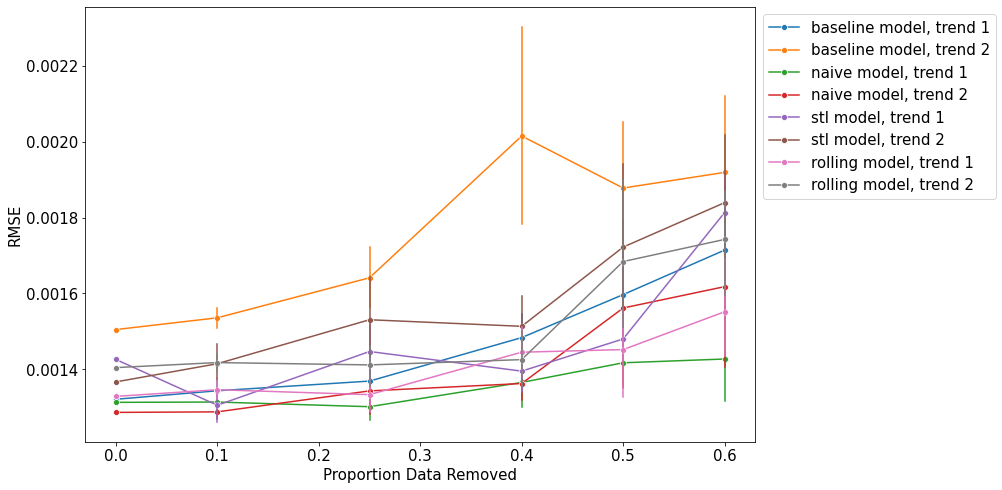

In [51]:
import seaborn as sns
plt.figure(figsize=(12,8))
for model in pd.unique(error_dfs_all['model']):
    for trend in pd.unique(error_dfs_all['trend']):
        df=error_dfs_all.loc[(error_dfs_all['model']==model)&(error_dfs_all['trend']==trend)]
        # add plot to line
        ax=sns.lineplot(x = "remove",
                     y = "rmse",
                     data = df,
                    label=f'{model} model, trend {trend}',
                     marker='o',
                       err_style='bars')

# add labels and legend
plt.xlabel('Proportion Data Removed')
plt.rcParams.update({'font.size':15})
plt.ylabel('RMSE')
sns.move_legend(ax,'upper left',bbox_to_anchor=(1,1))
plt.show()

In [15]:
bagged, rmse, mase, resid_percent=run_full_model(pro_data,10,remove=0.5,add_trend=True, trend_df=trend1_df, noise=0,
              blocks=True, model='stl')

In [16]:
rmse, mase, resid_percent

(0.0017325653997115895, 1.6398404801201094, 26.05042016806723)

### get necessary data for annette's model

In [197]:
# in 10 days, first sunrise starts at idx 7 (hour 14 in experiment)
# next sunrise occurs 24 hours later (idx 19, hour 38)#
# "day" lengths are 16 hours (night are 8)
sunrise_hours=np.arange(7, len(ten_days), 12)
sunrise_abund=ten_days.loc[sunrise_hours, 'abundance']
day_len=16

## Calculate growth rate
Growth rate is calculate by fitting an exponential cellullar growth function to the Qc data. This is equivalent to calculating the linear relationship of growth to the log Qc at a given time for each day: 

$ln(Qc) = r \times t + ln(Qc_0)$

Then, slope (r) is tested to be significant or not via p-value (<=0.05). 
<br>
OHhh this is the daily averaged cellular growth rate (h-1)

In [173]:
# y = mx+b
# y-b=mx
## 1: subtract y intercept from original y
## 2: fit linear regression model to mx (on centered y)
## 3: add y intercept back to adjust values

-3.209012407231112 [0.0816897] 0.9120935456642124


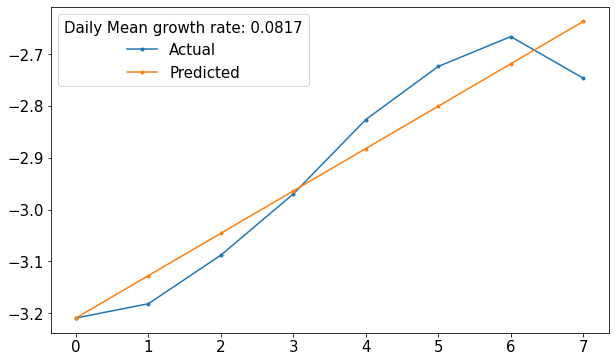

In [215]:
from sklearn.linear_model import LinearRegression
# get data to fit
day1_test = ten_days.loc[(ten_days['experiment_day']==1) &(ten_days['par']>0)]
X = np.arange(0, len(day1_test)).reshape(-1, 1)
y = np.log(day1_test['Qc_hour'].values)

# add y intercent, log Qc at sunrise
y_int=np.log(day1_test.loc[day1_test.hour%24==0, 'Qc_hour']).values[0]

# Step 1: Subtract the known y-intercept from all y values
y_centered = y - y_int

# Step 2: Fit the linear regression model
model = LinearRegression(fit_intercept=False)
model.fit(X, y_centered)

# Step 3: Add the known y-intercept back to the model's intercept
model.intercept_ += y_int

# step 4: get new y values
pred=model.predict(X)
slope=model.coef_

print(model.intercept_, model.coef_, model.score(X, y))
# plot
fig,axs=plt.subplots(figsize=(10,6))
# plot original values
axs.plot(X.flatten(),y.flatten(), marker='.', label='Actual')
# plot new predicted valyes
axs.plot(X.flatten(), pred.flatten(), marker='.', label='Predicted')
axs.legend(title=f'Daily Mean growth rate: {np.round(slope[0],4)}')

In [100]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

day1_test = ten_days.loc[ten_days['experiment_day']==1]
X = day1_test['hour']
Y = np.log(day1_test['Qc_hour'])
# add y intercent, log Qc at sunrise
y_int=np.log(day1_test.loc[day1_test.hour%24==0, 'Qc_hour']).values[0]
X = sm.add_constant(X)
X.const=y_int
# fit linear gression
model=sm.OLS(Y,X).fit()

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Qc_hour   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                 -0.049
Method:                 Least Squares   F-statistic:                    0.4831
Date:                Sun, 28 Jan 2024   Prob (F-statistic):              0.503
Time:                        13:32:05   Log-Likelihood:                 3.4278
No. Observations:                  12   AIC:                            -2.856
Df Residuals:                      10   BIC:                            -1.886
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8668      0.093      9.281      0.000       0.659       1.075
hour          -0.0058      0.008     -0.695      0.503      -0.024       0.013
==============================================================================
Omnibus:                        2.212   Durbin-Watson:                   0.290
Prob(Omnibus):                  0.331   Jarque-Bera (JB):                0.932
Skew:                           0.109   Prob(JB):                        0.628
Kurtosis:                       1.653   Cond. No.                         58.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
import statsmodels.api as sm
def fit_regression(group):
    X = group['hour']
    y = group['Qc'].apply(lambda x: 0 if x == 0 else np.log(x))  # Avoid log of zero
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X).fit()  # Fit linear regression
    return model.summary2().tables[1]

In [57]:
# loop through each day
for day in pd.unique(ten_days['experiment_day']):
    # get subset and light values only 
    sub = ten_days.loc[(ten_days['experiment_day'] == day)&
                       (ten_days['par']>0)]
    # fit linear regression
    

,hour,Qc_hour,par,abundance,GPP,carbonloss,NPP,experiment_day
0,0,0.043129,148.279626,64246741,4.948369e-03,0.002057,0.002891,0
1,2,0.047061,199.521423,66670700,6.556686e-03,0.003401,0.003156,0
2,4,0.053032,226.445848,66973949,7.574984e-03,0.003777,0.003798,0
3,6,0.060581,226.069041,62140320,8.414698e-03,0.005229,0.003185,0
4,8,0.066867,224.277784,65727501,7.187658e-03,0.004913,0.002275,0
...,...,...,...,...,...,...,...,...
115,230,0.058370,0.000000,143526371,4.005195e-05,0.001653,-0.001613,9
116,232,0.050111,0.000000,157966322,-2.800356e-07,-0.001469,0.001468,9
117,234,0.044922,0.000000,186351250,7.095304e-07,-0.000064,0.000065,9
118,236,0.041898,0.000000,200282742,-1.809134e-08,-0.000978,0.000978,9


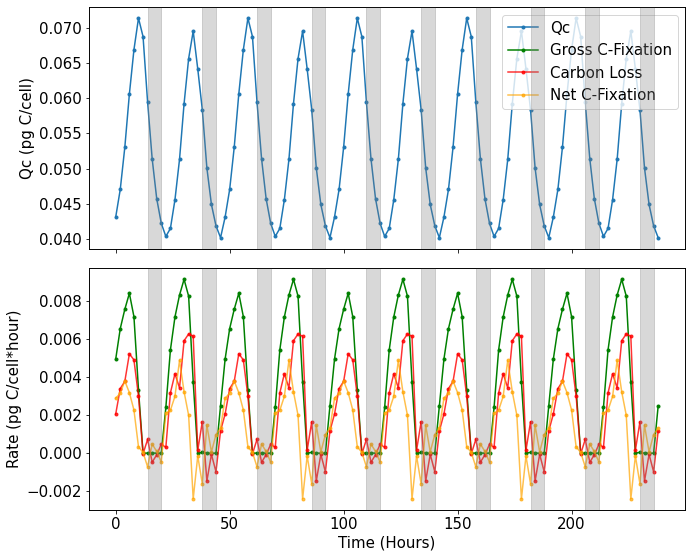

In [20]:
plot_simulated_rates(ten_days)

In [ ]:
## calculate carbon specific growth rate
# figure out when "sunrise" and "sunset is


## Let's look at noise while my other models are running
Vary noise using Signal to Noise Ratio

In [220]:
# calculates the signal to noise ratio
def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

signaltonoise(ten_days.Qc_hour[1:])

array(5.22876578)

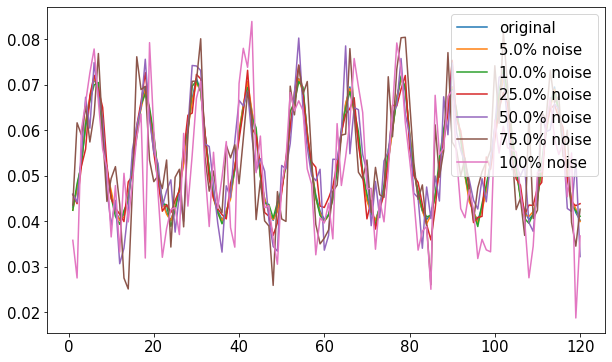

In [285]:
# add gaussian noise by varying std
def gaussian_noise(x,mu,std):
    noise = np.random.normal(mu, std, size = x.shape)
    x_noisy = x + noise
    return x_noisy 

# data
x=ten_days.Qc_hour
# mean of noise = 0
mu=0.0

# make plot
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(x, label='original')

# vary the standard deviation by percentage
noise_percents=[0.05, 0.1, 0.25, 0.5, 0.75, 1]
for noise in noise_percents:
    # calculate std to sample from noise
    std = noise * np.std(x) 
    # add noise to data
    x_noisy=gaussian_noise(x,mu,std)
    axs.plot(x_noisy, label=f'{noise*100}% noise')
axs.legend(loc='upper right')

In [251]:
# number of trials to run
n_trials = 10
# data
x=ten_days.Qc_hour
samples=np.tile(x,(4,1))

fig_snr = []

# loop through trials and add noise
for idx, noise in enumerate([0.01, .10, .50, 1]):
    samples[idx] += np.random.randn(samples[idx].shape[0]) * noise

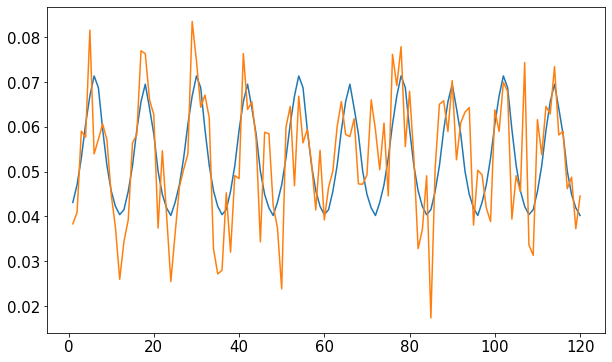

In [255]:
fig,axs=plt.subplots(figsize=(10,6))
axs.plot(x, label='original')
axs.plot(samples[0])

## How do I compare the residual mean to 1?
1 sample t-test?

<AxesSubplot:>

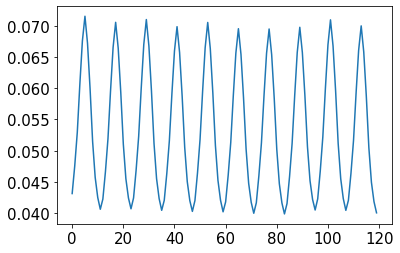

In [51]:
test_mbb=pd.concat(mbb_data)
# get trend and diel components from mean bagged values
diel_bagged=calc_95CI(test_mbb, 'hour', 'diel')
diel=diel_bagged['diel_mean']
trend_bagged=calc_95CI(test_mbb, 'hour', 'trend')
trend=trend_bagged['trend_mean']


In [108]:
sim_df=generate_simulated(pro_data, 10)
missing_25=generate_missing_data(sim_df, 'Qc_hour', 0.25)
impute_df=run_imputation(missing_25)
tsd_df=run_naive(impute_df, 'with_missing')
mbb_df, mbb_data=run_bootstrapping(tsd_df, model='naive')
bagged=bagging_results(mbb_data)

days_only = bagged.loc[bagged['par']>0]
# calculate error metrics
pred=days_only.productivity_mean[:-1]
actual=days_only.NPP[:-1]
rmse, smape, mase=error_metrics(pred, actual)

In [38]:
resid_hours=find_bad_resids(mbb_data)
resid_percent=bad_resid_percent(resid_hours, bagged)

In [39]:
resid_percent

11.76470588235294

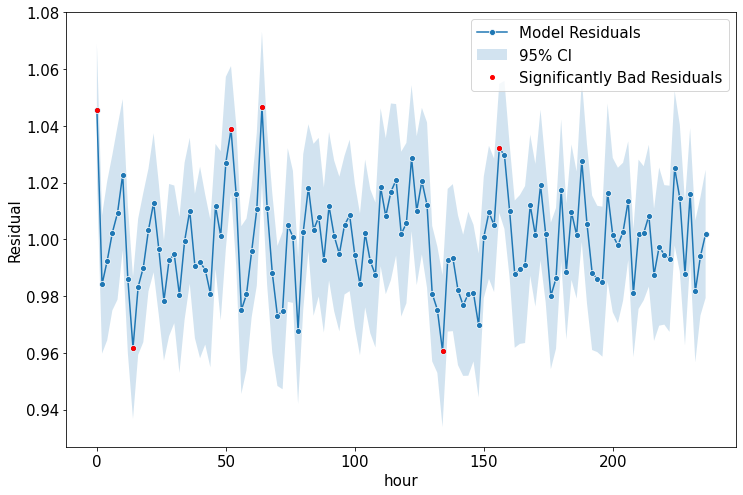

In [27]:
import seaborn as sns
# figure of residuals and 95 CI
plt.figure(figsize=(12,8))
bagged_stats=bagged.reset_index()
ax = sns.lineplot(data=bagged_stats, x="hour", y="resid_mean", palette="tab10", marker='o', 
                  label='Model Residuals')
plt.rcParams.update({'font.size':15})
# for i, (name, group) in enumerate(bagged_stats.groupby("size")):
x = bagged_stats['hour']

# add 95 CI range
lower = bagged_stats['resid_ci95_lo']
upper = bagged_stats['resid_ci95_hi']
plt.fill_between(x, lower, upper, alpha=0.2, label='95% CI')

# plot where residuals are significantly different from 1
resid_df=bagged_stats.loc[bagged_stats['resid_flag']==1]
plt.plot(resid_df.hour, resid_df.resid_mean, c='red', linestyle='', marker='.', markersize=8, 
         label='Significantly Bad Residuals')
plt.ylabel('Residual')
plt.legend()

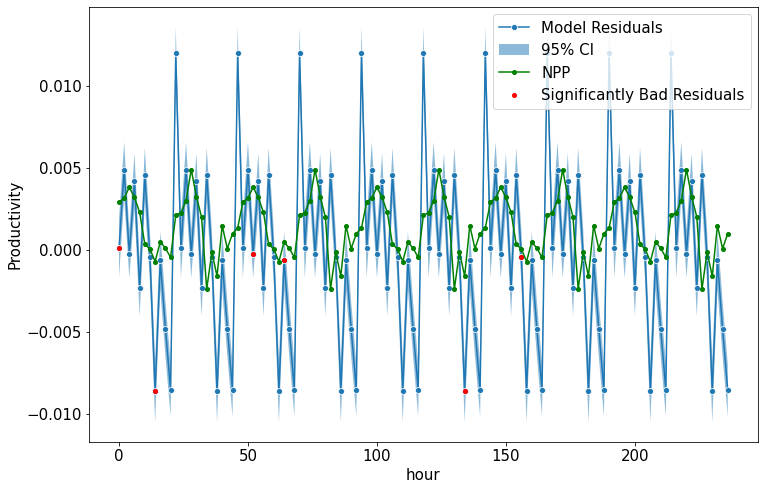

In [41]:
import seaborn as sns
# figure of residuals and 95 CI
plt.figure(figsize=(12,8))
bagged_stats=bagged.reset_index()
ax = sns.lineplot(data=bagged_stats, x="hour", y="productivity_mean", palette="tab10", marker='o', 
                  label='Model Residuals')
plt.rcParams.update({'font.size':15})
# for i, (name, group) in enumerate(bagged_stats.groupby("size")):
x = bagged_stats['hour']

# add 95 CI range
# lower = bagged_stats['productivity_ci95_lo']
# upper = bagged_stats['productivity_ci95_hi']
lower=bagged_stats['productivity_mean']-bagged_stats['productivity_std']
upper=bagged_stats['productivity_mean']+bagged_stats['productivity_std']
plt.fill_between(x, lower, upper, alpha=0.5, label='95% CI')

# plot true NPP
plt.plot(bagged_stats.hour, bagged_stats.NPP, c='green', marker='.', markersize=8, 
         label='NPP')

# plot where residuals are significantly different from 1
resid_df=bagged_stats.loc[bagged_stats['resid_flag']==1]
plt.plot(resid_df.hour, resid_df.productivity_mean, c='red', linestyle='', marker='.', markersize=8, 
         label='Significantly Bad Residuals')

plt.ylabel('Productivity')
plt.legend()

In [39]:
bagged

,resid_mean,resid_std,resid_ci95_hi,resid_ci95_lo,productivity_mean,productivity_std,productivity_ci95_hi,productivity_ci95_lo,par,NPP,resid_flag
hour,,,,,,,,,,,
0,1.045630,0.119867,1.069124,1.022136,0.000078,0.001798,0.000430,-0.000275,148.279626,0.002891,1
2,0.984152,0.124353,1.008526,0.959779,0.004865,0.001695,0.005197,0.004533,199.521423,0.003156,0
4,0.992513,0.143069,1.020554,0.964471,-0.000261,0.001453,0.000023,-0.000546,226.445848,0.003798,0
6,1.002407,0.139915,1.029830,0.974984,0.004170,0.001699,0.004503,0.003837,226.069041,0.003185,0
8,1.009331,0.155816,1.039871,0.978791,-0.002357,0.001701,-0.002023,-0.002690,224.277784,0.002275,0
...,...,...,...,...,...,...,...,...,...,...,...
228,0.987970,0.129021,1.013258,0.962682,-0.000416,0.001582,-0.000106,-0.000726,6.211792,-0.000145,0
230,1.015859,0.119095,1.039201,0.992516,-0.008636,0.001867,-0.008270,-0.009002,0.000000,-0.001613,0
232,0.981684,0.127271,1.006629,0.956739,-0.000654,0.001759,-0.000310,-0.000999,0.000000,0.001468,0


## Residuals and Uncertainty
I can get a percentage of data points that are sigfnicantly different from a mean of 1. These values are likely to be more uncertain than the other data points. 

How can I calculate uncertainty in growth rate or productivity from the residuals itself?

In [5]:
bagged, rmse, smape, mase=run_full_model(pro_data, 10, 0,noise=0.25, model='naive')

In [111]:
test0=test_mbb.iloc[0]
pred=test0.trend*test0.diel
actual=test0.Qc_hour
print(actual)

0.04312857598609022


In [114]:
pred

0.04337745436195357

In [115]:
(1-test0.resid)*100

2.5916285347124757

In [112]:
pred*test0.resid

0.042253271877077295